<a href="https://colab.research.google.com/github/evroth/gsb545repo/blob/main/Lab3_Bagging_Stacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Bagging and Stacking
Can we predict Sleep Score (posted by the FitBit app) using the other metrics in the dataset? In other words, is there a formula here that the FitBit app uses to compute Sleep Score that we can reverse-engineer?


## The Data
*note:* data should be saved locally, this will not run without it

In [67]:
import pandas as pd

In [68]:
# Read in Data
df_nov = pd.read_csv("November.csv")
df_dec = pd.read_csv("December.csv")
df_jan = pd.read_csv("January.csv")
df_feb = pd.read_csv("February.csv")
df_mar = pd.read_csv("March.csv")
df_apr = pd.read_csv("April.csv")

In [69]:
df_mar.head()

,MARCH,DATE,SLEEP SCORE,HOURS OF SLEEP,REM SLEEP,DEEP SLEEP,HEARTRATE BELOW RESTING,SLEEP TIME
0,Tuesday,03/01/2022,81.0,6:47:00,19.00%,15.00%,91.00%,11:32pm - 7:42am
1,Wednesday,03/02/2022,86.0,7:36:00,14.00%,17.00%,97.00%,11:02pm - 7:41am
2,Thursday,03/03/2022,83.0,7:59:00,20.00%,13.00%,44.00%,11:07pm - 8:01am
3,Friday,03/04/2022,84.0,8:29:00,18.00%,13.00%,99.00%,10:42pm - 8:44am
4,Saturday,03/05/2022,87.0,8:30:00,20.00%,19.00%,72.00%,11:33pm - 9:10am


In [70]:
df_nov.sample(5)

,NOVEMBER,DATE,SLEEP SCORE,HOURS OF SLEEP,REM SLEEP,DEEP SLEEP,HEART RATE BELOW RESTING,SLEEP TIME
17,Wednesday,11/17/2021,78.0,6:57:00,15.00%,14.00%,67.00%,11:50pm - 7:50am
12,Friday,11/12/2021,85.0,7:28:00,18.00%,16.00%,74.00%,10:21pm - 6:47am
25,Thursday,11/25/2021,81.0,6:51:00,20.00%,17.00%,51.00%,12:50am - 8:27am
27,Saturday,11/27/2021,86.0,7:53:00,24.00%,19.00%,66.00%,12:51am - 10:04am
20,Saturday,11/20/2021,86.0,7:56:00,24.00%,17.00%,63.00%,10:53pm - 7:59am


In [71]:
# Remove the first empty row 
df_nov = df_nov.iloc[1: ,]
df_dec = df_dec.iloc[1: ,]
df_jan = df_jan.iloc[1: ,]

# Rename column into 'Day'
df_nov.columns = df_nov.columns.str.replace('NOVEMBER', 'Day of Week')
df_dec.columns = df_dec.columns.str.replace('DECEMBER', 'Day of Week')
df_jan.columns = df_jan.columns.str.replace('JANUARY', 'Day of Week').str.replace('HEART RATE UNDER RESTING', 'HEART RATE BELOW RESTING')
df_feb.columns = df_feb.columns.str.replace('FEBEUARY', 'Day of Week').str.replace('SLEEP SQORE', 'SLEEP SCORE')
df_mar.columns = df_mar.columns.str.replace('MARCH', 'Day of Week').str.replace('HEARTRATE BELOW RESTING', 'HEART RATE BELOW RESTING')
df_apr.columns = df_apr.columns.str.replace('APRIL', 'Day of Week')

# Union and reindex data for four months
df_all = pd.concat([df_nov, df_dec, df_jan, df_feb, df_mar, df_apr], ignore_index=True)
df_all.head(7)

,Day of Week,DATE,SLEEP SCORE,HOURS OF SLEEP,REM SLEEP,DEEP SLEEP,HEART RATE BELOW RESTING,SLEEP TIME
0,Monday,11/1/2021,88.0,8:06:00,20.00%,13.00%,84.00%,10:41pm - 7:54am
1,Tuesday,11/2/2021,83.0,7:57:00,12.00%,18.00%,90.00%,10:40pm - 7:55am
2,Wednesday,11/3/2021,81.0,7:06:00,13.00%,22.00%,93.00%,11:03pm - 7:16am
3,Thursday,11/4/2021,86.0,7:04:00,19.00%,17.00%,97.00%,10:55pm - 6:56am
4,Friday,11/5/2021,81.0,9:24:00,17.00%,15.00%,66.00%,10:14pm - 9:01am
5,Saturday,11/6/2021,77.0,8:19:00,14.00%,13.00%,21.00%,11:21 - 8:45am
6,Sunday,11/7/2021,86.0,7:37:00,20.00%,15.00%,80.00%,11:18pm - 6:57am


In [72]:
df_all.dtypes

Day of Week                  object
DATE                         object
SLEEP SCORE                 float64
HOURS OF SLEEP               object
REM SLEEP                    object
DEEP SLEEP                   object
HEART RATE BELOW RESTING     object
SLEEP TIME                   object
dtype: object

In [73]:
# Split WAKE UP TIME & BED TIME
df_all['BED TIME'], df_all['WAKE UP TIME'] = df_all['SLEEP TIME'].astype(str).str.split(" - ", 1).str

print(df_all[df_all['BED TIME'].str.endswith('m')== False])
print(df_all[df_all['WAKE UP TIME'].str.endswith('m')== False ])
print(df_all[df_all['BED TIME'].str.contains('-')])

import warnings
warnings.filterwarnings("ignore")

    Day of Week        DATE  SLEEP SCORE HOURS OF SLEEP REM SLEEP DEEP SLEEP  \
5      Saturday   11/6/2021         77.0        8:19:00    14.00%     13.00%   
125      Sunday  03/06/2022          NaN            NaN       NaN        NaN   
138    Saturday  03/19/2022          NaN            NaN       NaN        NaN   

    HEART RATE BELOW RESTING      SLEEP TIME BED TIME WAKE UP TIME  
5                     21.00%  11:21 - 8:45am    11:21       8:45am  
125                      NaN             NaN      nan          NaN  
138                      NaN             NaN      nan          NaN  
   Day of Week        DATE  SLEEP SCORE HOURS OF SLEEP REM SLEEP DEEP SLEEP  \
37   Wednesday  12/08/2021         85.0        6:47:00    22.00%     16.00%   
57     Tuesday  12/28/2021         85.0        6:57:00    20.00%     18.00%   

   HEART RATE BELOW RESTING      SLEEP TIME BED TIME WAKE UP TIME  
37                   94.00%  11:40pm - 7:33  11:40pm         7:33  
57                   99.00%  

In [74]:
# Insert am/pm into WAKE UP TIME & BED TIME 
df_all['BED TIME'] = df_all['BED TIME'].replace(['11:21'],'11:21pm')
df_all['BED TIME'] = df_all['BED TIME'].replace(['11-38pm'],'11:38pm')
df_all['WAKE UP TIME'] = df_all['WAKE UP TIME'].replace(['7:33'],'7:33am')
df_all['WAKE UP TIME'] = df_all['WAKE UP TIME'].replace(['7:02'],'7:02am')

In [75]:
df_all = df_all[df_all['DATE'] != '03/06/2022']
df_all = df_all[df_all['DATE'] != '03/19/2022']

In [76]:
# Change Day into numeric variable
Day_index = []

for row in df_all['Day of Week']:
  if "Monday" in row: day = 1
  elif "Tuesday" in row: day = 2
  elif "Wednesday" in row: day = 3
  elif "Thursday" in row: day = 4
  elif "Friday" in row: day = 5
  elif "Saturday" in row: day = 6
  elif "Sunday" in row: day = 7
  Day_index.append(day)

df_all['DOW Index'] = Day_index

# Set datetime for dates 
df_all['DATE'] = pd.to_datetime(df_all['DATE'], format = '%m/%d/%Y', errors = 'coerce')
df_all['YEAR'] = df_all['DATE'].dt.year
df_all['MONTH'] = df_all['DATE'].dt.month
df_all['DAY'] = df_all['DATE'].dt.day

# Replace Hours of Sleep with Minutes of Sleep
df_all['HOURS OF SLEEP'] = df_all['HOURS OF SLEEP'].str.replace(':00', "")
df_all['Hours of Sleep'], df_all['Minutes of Sleep'] = df_all['HOURS OF SLEEP'].astype(str).str.split(":", 1).str
df_all['MINUTES of Sleep'] = pd.to_numeric(df_all['Hours of Sleep'])*60 + pd.to_numeric(df_all['Minutes of Sleep'])

# Change % into numberic variables
def set_percentage(x): 
  x = x.str.replace('%', "")
  x = pd.to_numeric(x)/100
  return(x)

df_all['REM SLEEP'] = set_percentage(df_all['REM SLEEP'])
df_all['DEEP SLEEP'] = set_percentage(df_all['DEEP SLEEP'])
df_all['HEART RATE BELOW RESTING'] = set_percentage(df_all['HEART RATE BELOW RESTING'])

#  Set datetime for time
df_all['WAKE UP TIME'] = pd.to_datetime(df_all['WAKE UP TIME'].str.replace('pm', 'PM').str.replace('am', 'AM'))
df_all['BED TIME'] = pd.to_datetime(df_all['BED TIME'].str.replace('pm', 'PM').str.replace('am', 'AM'))
df_all['WAKE UP HOUR'] = df_all['WAKE UP TIME'].dt.hour
df_all['WAKE UP MINUTE'] = df_all['WAKE UP TIME'].dt.minute
df_all['BED TIME HOUR'] = df_all['BED TIME'].dt.hour
df_all['BED TIME MINUTE'] = df_all['BED TIME'].dt.minute

# Remove date for time column
df_all['WAKE UP TIME'] = df_all['WAKE UP TIME'].dt.time 
df_all['BED TIME']  = df_all['BED TIME'] .dt.time

import warnings
warnings.filterwarnings("ignore")

In [77]:
df_all.head()

,Day of Week,DATE,SLEEP SCORE,HOURS OF SLEEP,REM SLEEP,DEEP SLEEP,HEART RATE BELOW RESTING,SLEEP TIME,BED TIME,WAKE UP TIME,...,YEAR,MONTH,DAY,Hours of Sleep,Minutes of Sleep,MINUTES of Sleep,WAKE UP HOUR,WAKE UP MINUTE,BED TIME HOUR,BED TIME MINUTE
0,Monday,2021-11-01,88.0,8:06,0.20,0.13,0.84,10:41pm - 7:54am,22:41:00,07:54:00,...,2021,11,1,8,06,486.0,7,54,22,41
1,Tuesday,2021-11-02,83.0,7:57,0.12,0.18,0.90,10:40pm - 7:55am,22:40:00,07:55:00,...,2021,11,2,7,57,477.0,7,55,22,40
2,Wednesday,2021-11-03,81.0,7:06,0.13,0.22,0.93,11:03pm - 7:16am,23:03:00,07:16:00,...,2021,11,3,7,06,426.0,7,16,23,3
3,Thursday,2021-11-04,86.0,7:04,0.19,0.17,0.97,10:55pm - 6:56am,22:55:00,06:56:00,...,2021,11,4,7,04,424.0,6,56,22,55
4,Friday,2021-11-05,81.0,9:24,0.17,0.15,0.66,10:14pm - 9:01am,22:14:00,09:01:00,...,2021,11,5,9,24,564.0,9,1,22,14


In [78]:
df_all.dtypes

Day of Week                         object
DATE                        datetime64[ns]
SLEEP SCORE                        float64
HOURS OF SLEEP                      object
REM SLEEP                          float64
DEEP SLEEP                         float64
HEART RATE BELOW RESTING           float64
SLEEP TIME                          object
BED TIME                            object
WAKE UP TIME                        object
DOW Index                            int64
YEAR                                 int64
MONTH                                int64
DAY                                  int64
Hours of Sleep                      object
Minutes of Sleep                    object
MINUTES of Sleep                   float64
WAKE UP HOUR                         int64
WAKE UP MINUTE                       int64
BED TIME HOUR                        int64
BED TIME MINUTE                      int64
dtype: object

In [79]:
df_final = df_all.drop(columns=['HOURS OF SLEEP', 'SLEEP TIME'])
df_final.head(10)

,Day of Week,DATE,SLEEP SCORE,REM SLEEP,DEEP SLEEP,HEART RATE BELOW RESTING,BED TIME,WAKE UP TIME,DOW Index,YEAR,MONTH,DAY,Hours of Sleep,Minutes of Sleep,MINUTES of Sleep,WAKE UP HOUR,WAKE UP MINUTE,BED TIME HOUR,BED TIME MINUTE
0,Monday,2021-11-01,88.0,0.20,0.13,0.84,22:41:00,07:54:00,1,2021,11,1,8,06,486.0,7,54,22,41
1,Tuesday,2021-11-02,83.0,0.12,0.18,0.90,22:40:00,07:55:00,2,2021,11,2,7,57,477.0,7,55,22,40
2,Wednesday,2021-11-03,81.0,0.13,0.22,0.93,23:03:00,07:16:00,3,2021,11,3,7,06,426.0,7,16,23,3
3,Thursday,2021-11-04,86.0,0.19,0.17,0.97,22:55:00,06:56:00,4,2021,11,4,7,04,424.0,6,56,22,55
4,Friday,2021-11-05,81.0,0.17,0.15,0.66,22:14:00,09:01:00,5,2021,11,5,9,24,564.0,9,1,22,14
5,Saturday,2021-11-06,77.0,0.14,0.13,0.21,23:21:00,08:45:00,6,2021,11,6,8,19,499.0,8,45,23,21
6,Sunday,2021-11-07,86.0,0.20,0.15,0.80,23:18:00,06:57:00,7,2021,11,7,7,37,457.0,6,57,23,18
7,Monday,2021-11-08,81.0,0.16,0.17,0.89,23:50:00,07:40:00,1,2021,11,8,6,46,406.0,7,40,23,50
8,Tuesday,2021-11-09,88.0,0.24,0.19,0.98,23:14:00,07:16:00,2,2021,11,9,7,10,430.0,7,16,23,14
9,Wednesday,2021-11-10,84.0,0.21,0.17,0.96,23:16:00,07:29:00,3,2021,11,10,7,16,436.0,7,29,23,16


In [80]:
df_final.describe()

,SLEEP SCORE,REM SLEEP,DEEP SLEEP,HEART RATE BELOW RESTING,DOW Index,YEAR,MONTH,DAY,MINUTES of Sleep,WAKE UP HOUR,WAKE UP MINUTE,BED TIME HOUR,BED TIME MINUTE
count,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,178.000000,179.000000,179.000000,179.000000,179.000000
mean,84.195531,0.193911,0.171397,0.774860,3.955307,2021.659218,5.564246,15.636872,453.623596,7.240223,29.106145,19.357542,30.849162
std,6.299704,0.039153,0.036654,0.220913,1.991051,0.475302,4.393567,8.775411,43.392948,1.128463,19.191961,7.512954,17.543354
min,25.000000,0.080000,0.000000,0.000000,1.000000,2021.000000,1.000000,1.000000,253.000000,5.000000,0.000000,0.000000,0.000000
25%,82.000000,0.170000,0.150000,0.665000,2.000000,2021.000000,2.000000,8.000000,427.000000,7.000000,11.000000,22.000000,15.500000
50%,85.000000,0.200000,0.170000,0.840000,4.000000,2022.000000,4.000000,16.000000,452.000000,7.000000,29.000000,22.000000,33.000000
75%,87.000000,0.220000,0.190000,0.960000,6.000000,2022.000000,11.000000,23.000000,482.000000,8.000000,47.000000,23.000000,47.000000
max,93.000000,0.310000,0.270000,1.000000,7.000000,2022.000000,12.000000,31.000000,579.000000,11.000000,59.000000,23.000000,59.000000


## Visual Analysis

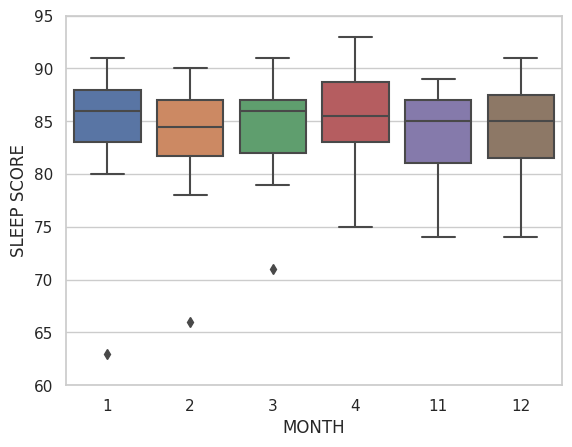

In [81]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
sns.boxplot(x = 'MONTH', y = 'SLEEP SCORE', data = df_final)
plt.ylim(60, 95)
plt.show()

<Axes: xlabel='Day of Week', ylabel='SLEEP SCORE'>

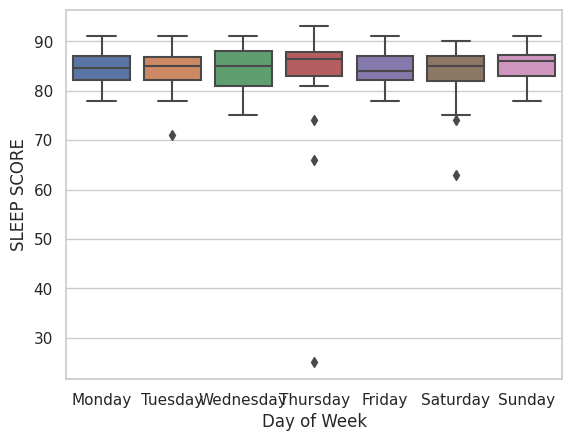

In [82]:
sns.boxplot(x = 'Day of Week', y = 'SLEEP SCORE', data = df_final)

<Axes: xlabel='DATE'>

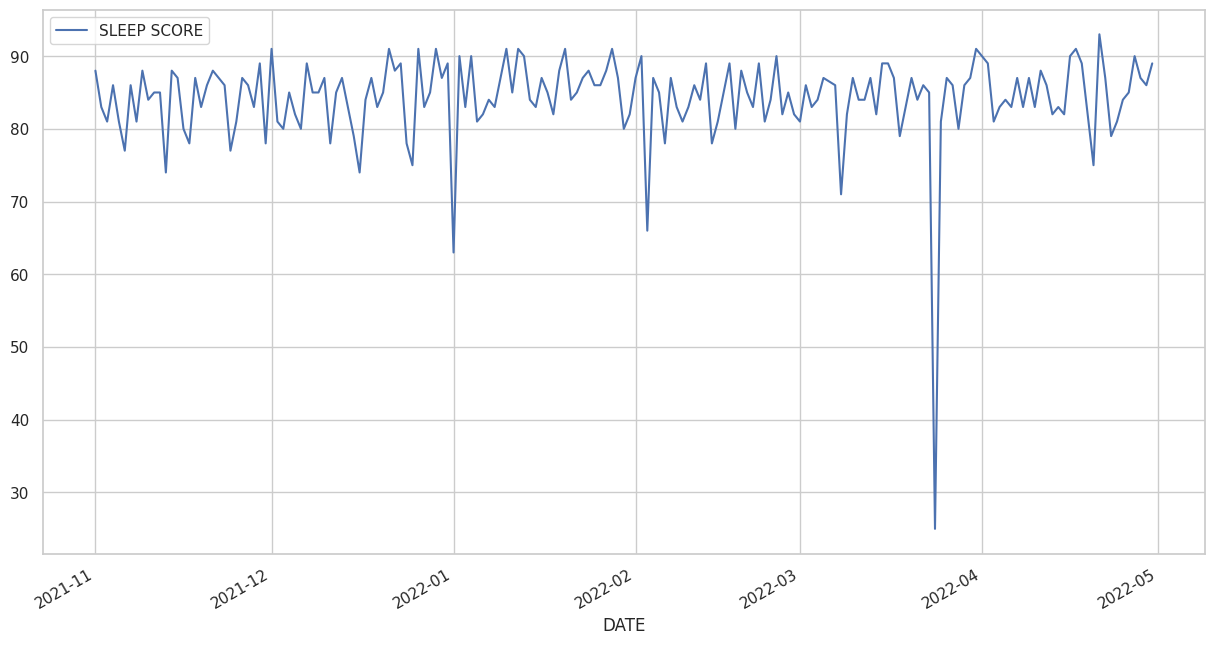

In [83]:
df_final.plot(x='DATE',y='SLEEP SCORE',figsize=(15,8))

<Axes: >

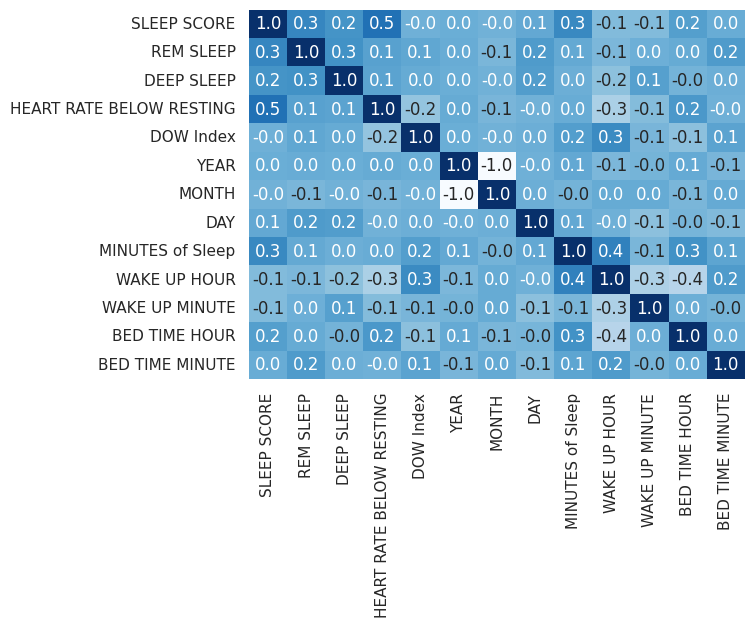

In [84]:
sns.heatmap(df_final.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')

<Axes: xlabel='MINUTES of Sleep', ylabel='SLEEP SCORE'>

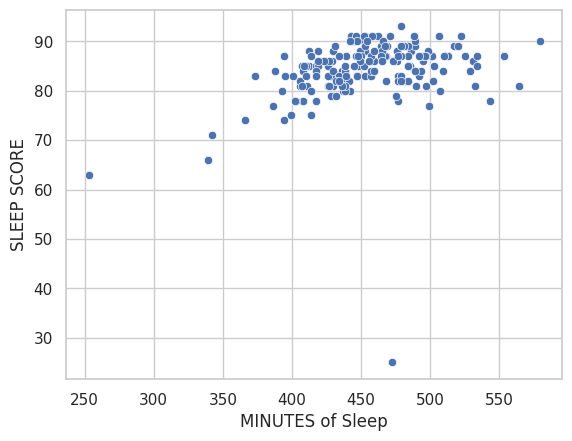

In [85]:
sns.scatterplot(x = 'MINUTES of Sleep', y = 'SLEEP SCORE', data = df_final)

<Axes: xlabel='HEART RATE BELOW RESTING', ylabel='SLEEP SCORE'>

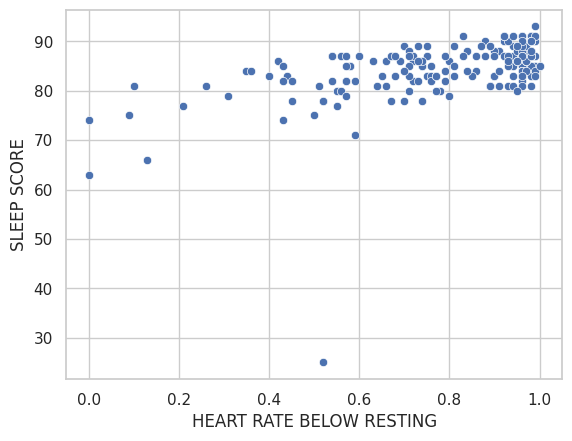

In [86]:
sns.scatterplot(x = 'HEART RATE BELOW RESTING', y = 'SLEEP SCORE', data = df_final)

## Building Models

In [122]:
df_model = pd.get_dummies(df_final, columns = ['DOW Index', 'YEAR', 'MONTH', 'DAY'])
df_model.drop(['Day of Week', 'DATE', 'Hours of Sleep', 'Minutes of Sleep', 'WAKE UP MINUTE', 'BED TIME MINUTE', 'BED TIME', 'WAKE UP TIME'], axis=1, inplace=True)
# had one missing value still so drop it
df_model.dropna(inplace=True)

In [123]:
# Separate features and target variable
X = df_model.drop(['SLEEP SCORE'], axis=1)

y = df_model['SLEEP SCORE']

In [124]:
df_model.head()

,SLEEP SCORE,REM SLEEP,DEEP SLEEP,HEART RATE BELOW RESTING,MINUTES of Sleep,WAKE UP HOUR,BED TIME HOUR,DOW Index_1,DOW Index_2,DOW Index_3,...,DAY_22,DAY_23,DAY_24,DAY_25,DAY_26,DAY_27,DAY_28,DAY_29,DAY_30,DAY_31
0,88.0,0.20,0.13,0.84,486.0,7,22,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,83.0,0.12,0.18,0.90,477.0,7,22,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,81.0,0.13,0.22,0.93,426.0,7,23,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,86.0,0.19,0.17,0.97,424.0,6,22,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,81.0,0.17,0.15,0.66,564.0,9,22,0,0,0,...,0,0,0,0,0,0,0,0,0,0


packages:

In [ ]:
#pip install vecstack

In [96]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from vecstack import stacking

Model 1

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [126]:
models = [
    KNeighborsRegressor(n_neighbors=5,
                        n_jobs=-1),
        
    RandomForestRegressor(random_state=0, n_jobs=-1, 
                           n_estimators=100, max_depth=3),
        
    XGBRegressor(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=100, max_depth=3)
]

In [127]:
S_train, S_test = stacking(models,                   
                           X_train, y_train, X_test,   
                           regression=True, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           #metric= mean_absolute_error, 
    
                           n_folds=4,
            
                           shuffle=True,  
            
                           random_state=0,    
         
                           verbose=2)

task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsRegressor]
    fold  0:  [3.16666667]
    fold  1:  [3.21111111]
    fold  2:  [2.71428571]
    fold  3:  [2.57142857]
    ----
    MEAN:     [2.91587302] + [0.27809279]
    FULL:     [2.91971831]

model  1:     [RandomForestRegressor]
    fold  0:  [1.92742684]
    fold  1:  [1.82600638]
    fold  2:  [1.81642722]
    fold  3:  [1.48264651]
    ----
    MEAN:     [1.76312674] + [0.16767414]
    FULL:     [1.76472659]

model  2:     [XGBRegressor]
    fold  0:  [1.49709066]
    fold  1:  [1.44427999]
    fold  2:  [1.44457070]
    fold  3:  [1.55128653]
    ----
    MEAN:     [1.48430697] + [0.04424595]
    FULL:     [1.48411512]



In [128]:
# Initialize 2nd level model
model = XGBRegressor(random_state=0, n_jobs=-1, learning_rate=0.1, 
                     n_estimators=100, max_depth=3)
    
# Fit 2nd level model
model = model.fit(S_train, y_train)

# Predict
y_pred = model.predict(S_test)

# Final prediction score
print('Final prediction score: [%.8f]' % mean_absolute_error(y_test, y_pred))

Final prediction score: [3.54719204]


Here in this first model we find a mean absolute error of 3.55. The first layers of the stacking model contained a knn model, random forest, and boosted tree. The final combination layer was another boosted tree composed of the first layer.

Model 2

In [129]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from matplotlib import pyplot

>knn -3.404 (1.242)
>cart -3.111 (1.597)
>svm -3.561 (1.427)


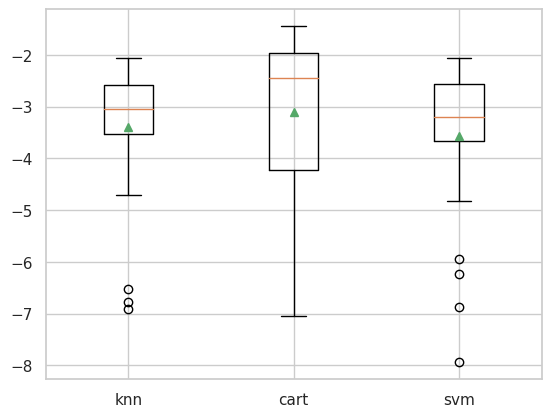

In [130]:
# get a list of models to evaluate
def get_models():
 models = dict()
 models['knn'] = KNeighborsRegressor()
 models['cart'] = DecisionTreeRegressor()
 models['svm'] = SVR()
 return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
 cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
 return scores
 
# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X, y)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [132]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from matplotlib import pyplot

>knn -3.404 (1.242)
>cart -2.957 (1.617)
>svm -3.561 (1.427)
>xbg -2.555 (1.316)
>stacking -2.711 (1.164)


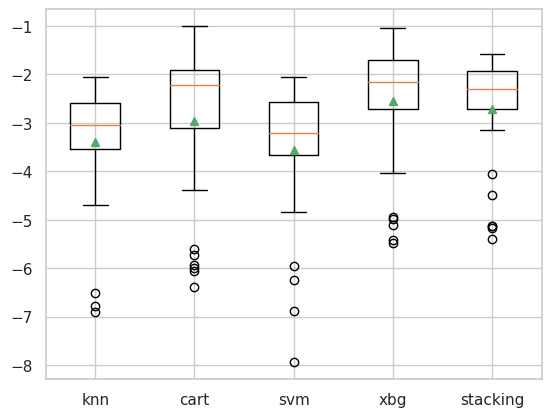

In [133]:
# get a stacking ensemble of models
def get_stacking():
 # define the base models
 level0 = list()
 level0.append(('knn', KNeighborsRegressor()))
 level0.append(('cart', DecisionTreeRegressor()))
 level0.append(('svm', SVR()))
 level0.append(('xbg', XGBRegressor()))
 # define meta learner model
 level1 = LinearRegression()
 # define the stacking ensemble
 model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
 return model
 
# get a list of models to evaluate
def get_models():
 models = dict()
 models['knn'] = KNeighborsRegressor()
 models['cart'] = DecisionTreeRegressor()
 models['svm'] = SVR()
 models['xbg'] = XGBRegressor()
 models['stacking'] = get_stacking()
 return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
 cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
 return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X, y)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Here in this second model we built something that performed a bit better. Of the first layer of models, the boosted tree outperforms all models with a MAE of 2.555, this is even better than when stacking is performed with all the models, which was an MAE of 2.711. This meta model used here was a linear regression; a different type of meta model may do a better job at capturing the best qualities of each individual model in the first group

>knn -3.404 (1.242)
>cart -2.974 (1.467)
>svm -3.561 (1.427)
>xbg -2.555 (1.316)
>stacking -2.883 (1.259)


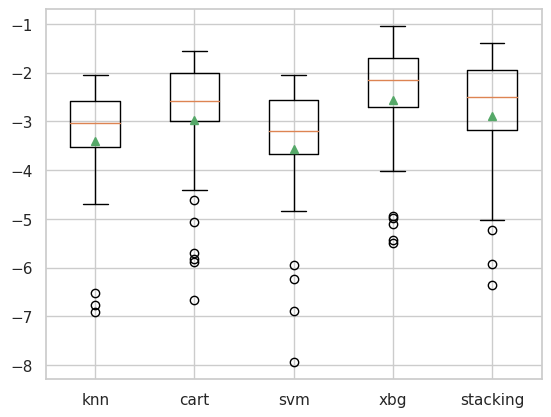

In [135]:
# get a stacking ensemble of models
def get_stacking():
 # define the base models
 level0 = list()
 level0.append(('knn', KNeighborsRegressor()))
 level0.append(('cart', DecisionTreeRegressor()))
 level0.append(('svm', SVR()))
 level0.append(('xbg', XGBRegressor()))
 # define meta learner model
 level1 = XGBRegressor()
 # define the stacking ensemble
 model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
 return model
 
# get a list of models to evaluate
def get_models():
 models = dict()
 models['knn'] = KNeighborsRegressor()
 models['cart'] = DecisionTreeRegressor()
 models['svm'] = SVR()
 models['xbg'] = XGBRegressor()
 models['stacking'] = get_stacking()
 return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
 cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
 return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X, y)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

From just playing around here above, it can be seen that using a boosted tree as the meta model performs worse than the initial linear regression in the previous example.

Model 3 *Simple bagging*

In [138]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import cross_val_score

model = BaggingRegressor(RandomForestRegressor(n_estimators = 100, random_state=7), n_estimators = 2, random_state = 7) 
cross_val_score(model,X,y,scoring="neg_mean_absolute_error",cv=10).mean()

-2.0291470588235287

From just this random forest regression using bagging we get better results than any of the stacking methods provided. The MAE of 2.03 is the lowest I have been able to get while playing around with some of the variables we can tweak.